In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as skl_train_test_split
from scipy.spatial import distance
from random import choice, randint
from surprise import KNNWithMeans, KNNBasic, Reader, Dataset, SVD, accuracy, SVDpp
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate

In [2]:
clicks_sample = pd.read_csv('news-portal-user-interactions-by-globocom/clicks_sample.csv')
article_data = pd.read_csv('news-portal-user-interactions-by-globocom/articles_metadata.csv')
with open('news-portal-user-interactions-by-globocom/articles_embeddings.pickle', 'rb') as handle:
    articles_embeddings = pickle.load(handle)
path = 'news-portal-user-interactions-by-globocom/clicks/clicks/'
all_files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]
list_of_dataframes = [pd.read_csv(file) for file in all_files]
clicks_data = pd.concat(list_of_dataframes, ignore_index=True)

In [3]:
article_data.article_id.count()

364047

In [4]:
articles_embeddings.shape

(364047, 250)

### Analyse descriptive

In [3]:
def preliminary_analysis(df: pd.DataFrame, n: int = 5):
    """
    Effectue une analyse préliminaire sur un DataFrame Pandas donné.
    
    Parameters:
    df (pd.DataFrame): Le DataFrame à analyser.
    n (int): Le nombre de premières lignes à afficher.
    """

    print(f"Premières {n} lignes du DataFrame:")
    display(df.head(n))
    print("\n" + "-" * 50 + "\n")
    
    print("Types de données de chaque colonne:")
    print(df.dtypes)
    print("\n" + "-" * 50 + "\n")
    
    print("Nombre de valeurs manquantes dans chaque colonne:")
    print(df.isnull().sum())
    print("\n" + "-" * 50 + "\n")
    
    print("Statistiques descriptives du DataFrame:")
    display(df.describe(include='all'))
    print("\n" + "-" * 50 + "\n")
    
    print("Nombre de valeurs uniques dans chaque colonne:")
    print(df.nunique())
    print("\n" + "-" * 50 + "\n")
    
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        print(f"Valeurs uniques dans la colonne {col}:")
        print(df[col].value_counts())
        print("\n" + "-" * 50 + "\n")

print("Analyse Clicks data")
preliminary_analysis(clicks_data)

Analyse Clicks data
Premières 5 lignes du DataFrame:


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2



--------------------------------------------------

Types de données de chaque colonne:
user_id                object
session_id             object
session_start          object
session_size           object
click_article_id       object
click_timestamp        object
click_environment      object
click_deviceGroup      object
click_os               object
click_country          object
click_region           object
click_referrer_type    object
dtype: object

--------------------------------------------------

Nombre de valeurs manquantes dans chaque colonne:
user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64

--------------------------------------------------

Statistiques descriptives du DataFrame:


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,646874,72,46033,2983198,3,5,8,11,28,7
top,5890,1507563657895091,1507563657000,2,160974,1506961009961,4,1,17,1,25,2
freq,1232,124,127,1260372,37213,3,2904478,1823162,1738138,2852406,804985,1602601



--------------------------------------------------

Nombre de valeurs uniques dans chaque colonne:
user_id                 322897
session_id             1048594
session_start           646874
session_size                72
click_article_id         46033
click_timestamp        2983198
click_environment            3
click_deviceGroup            5
click_os                     8
click_country               11
click_region                28
click_referrer_type          7
dtype: int64

--------------------------------------------------

Valeurs uniques dans la colonne user_id:
user_id
5890      1232
73574      939
15867      900
80350      783
15275      746
          ... 
227424       2
227423       2
227422       2
227421       2
322896       2
Name: count, Length: 322897, dtype: int64

--------------------------------------------------

Valeurs uniques dans la colonne session_id:
session_id
1507563657895091    124
1507896573228093    107
1507133567968022    106
1507309773225261     98
15

In [4]:
print("Analyse Article")
preliminary_analysis(article_data)

Analyse Article
Premières 5 lignes du DataFrame:


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162



--------------------------------------------------

Types de données de chaque colonne:
article_id       int64
category_id      int64
created_at_ts    int64
publisher_id     int64
words_count      int64
dtype: object

--------------------------------------------------

Nombre de valeurs manquantes dans chaque colonne:
article_id       0
category_id      0
created_at_ts    0
publisher_id     0
words_count      0
dtype: int64

--------------------------------------------------

Statistiques descriptives du DataFrame:


,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000



--------------------------------------------------

Nombre de valeurs uniques dans chaque colonne:
article_id       364047
category_id         461
created_at_ts    359552
publisher_id          1
words_count         866
dtype: int64

--------------------------------------------------



In [3]:
df = clicks_data.merge(article_data, left_on='click_article_id', right_on='article_id')
display(df)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,157541,281,1506800518000,0,280
1,20,1506825727279757,1506825727000,2,157541,1506836548634,4,1,17,1,9,1,157541,281,1506800518000,0,280
2,44,1506826139185781,1506826139000,5,157541,1506857278141,4,1,17,1,12,1,157541,281,1506800518000,0,280
3,45,1506826142324782,1506826142000,2,157541,1506827309970,4,1,17,1,17,1,157541,281,1506800518000,0,280
4,76,1506826463226813,1506826463000,2,157541,1506828823469,4,3,2,1,21,1,157541,281,1506800518000,0,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,195186,1508210422411129,1508210422000,4,2221,1508210469562,4,3,2,1,1,1,2221,1,1508192469000,0,103
2988177,75658,1508210696185183,1508210696000,4,271117,1508210951703,4,1,17,1,4,2,271117,399,1504276061000,0,156
2988178,217129,1508210976336246,1508210976000,2,20204,1508210990810,4,3,2,1,21,5,20204,9,1491934410000,0,242
2988179,217129,1508210976336246,1508210976000,2,70196,1508211020810,4,3,2,1,21,5,70196,136,1491298495000,0,206


In [4]:
def get_n_popular(df): 
    """
    Cette fonction prend un DataFrame en entrée, calcule la popularité de chaque article
    en fonction du nombre d'occurrences dans le DataFrame, trie les articles par popularité
    en ordre décroissant et retourne une liste des identifiants d'articles.

    Parameters:
    - df (DataFrame): DataFrame contenant des données sur les interactions des utilisateurs 
                      avec les articles.

    Returns:
    - list: Liste des identifiants des articles, triés par popularité en ordre décroissant.
    """
    article_popularity = df.groupby('article_id').size().reset_index(name='popularity')
    sorted_articles = article_popularity.sort_values(by='popularity', ascending=False)
    popular_articles = sorted_articles['article_id'].tolist()
    return popular_articles
popular_articles = get_n_popular(df)
popular_articles[:10]

[160974, 272143, 336221, 234698, 123909, 336223, 96210, 162655, 183176, 168623]

In [4]:
def create_interaction_mat(df):
    top_users = df['user_id'].value_counts().head(100).index
    top_articles = df['click_article_id'].value_counts().head(100).index

    # Filtrer le dataframe pour ne conserver que les interactions des top utilisateurs et articles.
    filtered_df = df[df['user_id'].isin(top_users) & df['click_article_id'].isin(top_articles)]

    # Créer la matrice d'interaction en utilisant pivot_table.
    user_article_matrix = filtered_df.pivot_table(index='user_id', 
                                                  columns='click_article_id', 
                                                  aggfunc='size', 
                                                  fill_value=0)

    # S'assurer que toutes les colonnes et tous les index sont présents, même s'il n'y a pas de données pour certains.
    # Cela est nécessaire car pivot_table ne créera pas de colonnes ou d'index pour les combinaisons sans données.
    user_article_matrix = user_article_matrix.reindex(index=top_users, columns=top_articles, fill_value=0)
    # Afficher la matrice d'interaction.
    display(user_article_matrix)
    return user_article_matrix

user_article_matrix = create_interaction_mat(df)

click_article_id,160974,272143,336221,234698,123909,336223,96210,162655,183176,168623,...,160132,96755,237524,161801,157478,119534,284844,315105,141004,16129
user_id,,,,,,,,,,,,,,,,,,,,,
5890,0,1,0,1,1,0,0,0,0,0,...,0,0,1,0,2,0,0,0,0,0
73574,1,0,1,1,1,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
15867,3,0,1,3,9,0,1,3,1,2,...,0,0,3,1,1,1,0,0,2,0
80350,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
15275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13407,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
1819,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11385,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


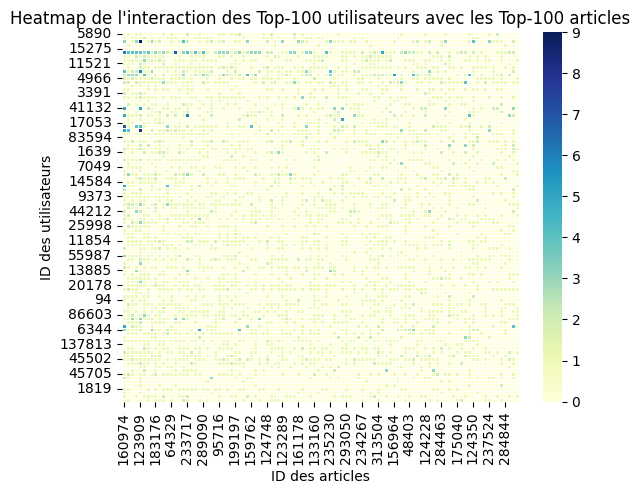

In [17]:
sns.heatmap(user_article_matrix , cmap="YlGnBu", linewidths=.5, annot=False)
plt.title('Heatmap de l\'interaction des Top-100 utilisateurs avec les Top-100 articles')
plt.xlabel('ID des articles')
plt.ylabel('ID des utilisateurs')
plt.show()

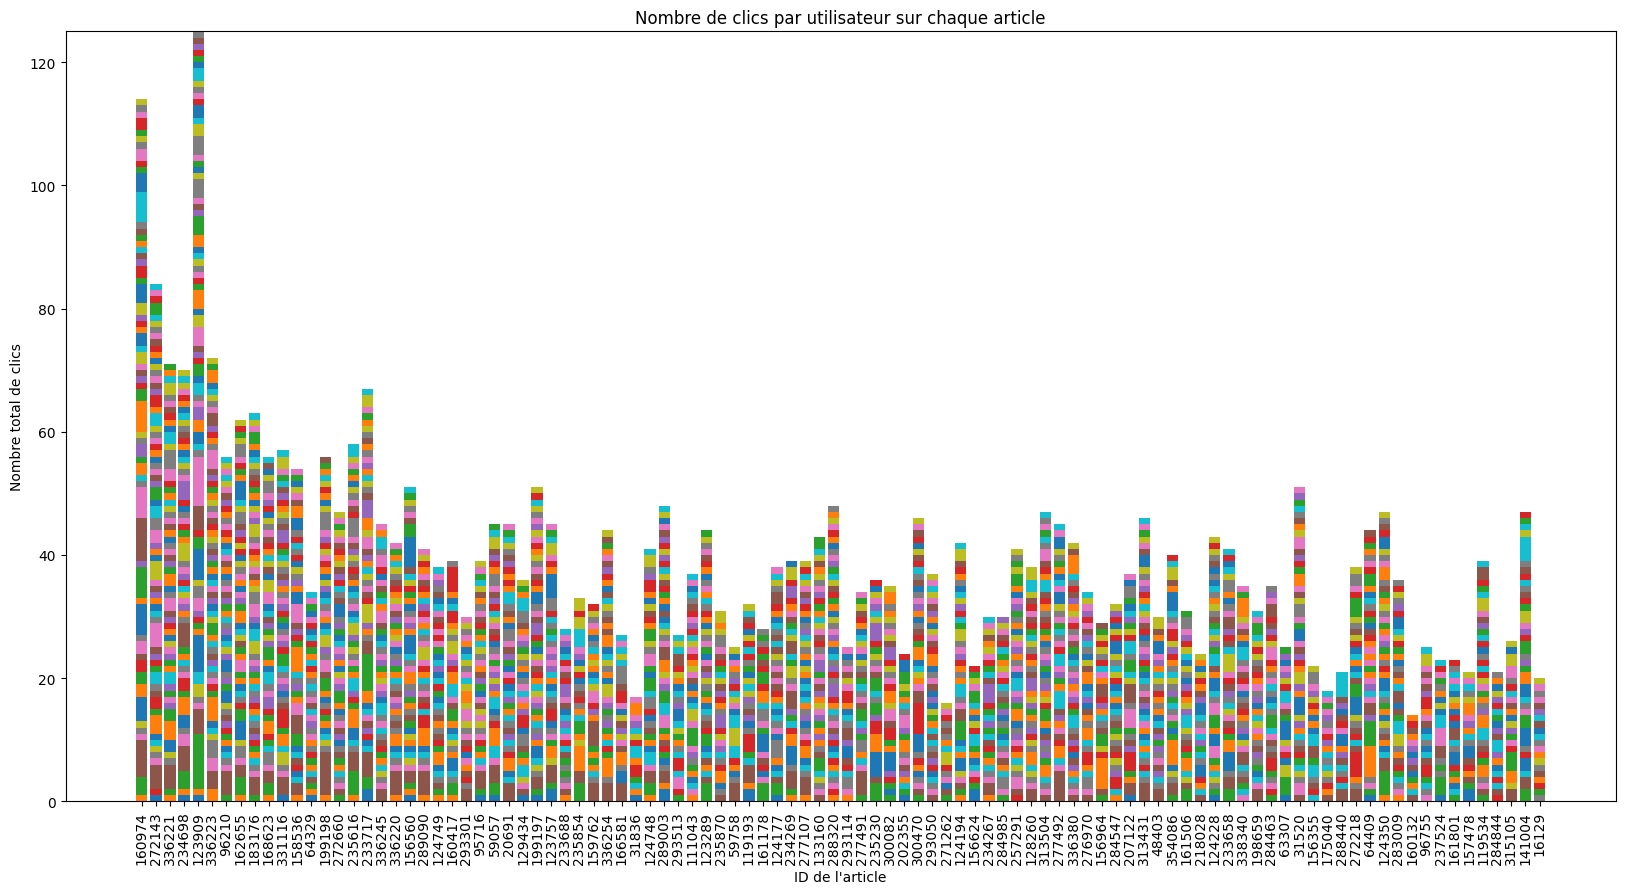

In [30]:
def create_stacked_barplot(user_article_matrix):
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ind = np.arange(user_article_matrix.shape[1]) 
    width = 0.8
    bottom = np.zeros(user_article_matrix.shape[1])

    for user in user_article_matrix.index:
        clicks = user_article_matrix.loc[user, :]
        ax.bar(ind, clicks, width, label=str(user), bottom=bottom)
        bottom += clicks

    ax.set_title('Nombre de clics par utilisateur sur chaque article')
    ax.set_xlabel('ID de l\'article')
    ax.set_ylabel('Nombre total de clics')
    ax.set_xticks(ind)
    ax.set_xticklabels(user_article_matrix.columns)
    plt.xticks(rotation=90)
    plt.show()

    
create_stacked_barplot(user_article_matrix)

## Création d'un rating implicite 

### Pourcentage des clics d'un utilisateur

In [5]:
def create_rating(df):
    """
    Cette fonction prend en entrée un DataFrame, calcule un score de popularité normalisée pour
    chaque pair utilisateur-article, basée sur le nombre de clics, et retourne un DataFrame trié 
    avec les nouveaux scores de popularité.

    Parameters:
    - df (DataFrame): DataFrame contenant des données sur les interactions des utilisateurs avec les articles.

    Returns:
    - DataFrame: DataFrame trié avec des colonnes supplémentaires telles que 'user_total_clicks', 
                 'article_user_clicks', et 'normalized_popularity'.
    """
    user_total_clicks = df.groupby('user_id').size().reset_index(name='user_total_clicks')
    df = df.merge(user_total_clicks, on='user_id')

    article_user_clicks = df.groupby(['user_id', 'article_id']).size().reset_index(name='article_user_clicks')
    article_user_clicks = article_user_clicks.merge(user_total_clicks, on='user_id')
    
    article_user_clicks['normalized_popularity'] = article_user_clicks['article_user_clicks'] / article_user_clicks['user_total_clicks']
    sorted_articles = article_user_clicks.sort_values(by='article_user_clicks', ascending= False)
    display(sorted_articles)
    
    return sorted_articles
sorted_articles = create_rating(df)

,user_id,article_id,article_user_clicks,user_total_clicks,normalized_popularity
349865,16280,68851,33,293,0.112628
349924,16280,237071,33,293,0.112628
349969,16280,363925,33,293,0.112628
349859,16280,43032,31,293,0.105802
349853,16280,38823,30,293,0.102389
...,...,...,...,...,...
992352,54285,97590,1,15,0.066667
992353,54285,156447,1,15,0.066667
992354,54285,156624,1,15,0.066667
992355,54285,158646,1,15,0.066667


In [6]:
with open("ratings.pkl", "wb") as f:
    pickle.dump(sorted_articles, f)

In [7]:
with open("ratings.pkl", "rb") as file:
    sorted_articles = pickle.load(file)

## Content-Based Filtering Model

### Recommandation avec l'Embedding
Le fichier article_embedding contient des embeddings d'articles, qui sont des représentations vectorielles des articles dans un espace à dimensions réduites.  
La méthode de calcul des préférences de l'utilisateur est calculée en prenant l'angle entre deux vecteurs de document.
La raison ultime de l'utilisation du cosinus est que la valeur du cosinus augmente à mesure que l'angle entre les vecteurs diminue, ce qui signifie une plus grande similarité.

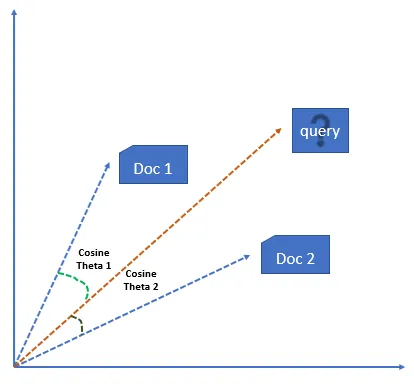  

**Similarité Cosinus:**  
- Indépendance de la Magnitude: La similarité cosinus mesure l'angle entre deux vecteurs, indépendamment de leur magnitude. Cela est souvent important dans le texte car un terme qui apparaît 10 fois dans deux documents différents peut toujours avoir le même "sens" ou "importance relative", même si un document est plus long que l'autre.  
- Espacement des Vecteurs: Dans les espaces à haute dimension, les vecteurs tendent à être "loin" les uns des autres en termes de distance euclidienne, même s'ils sont "similaires". La similarité cosinus peut mieux capturer cette similarité dans de tels espaces.  
- Utilisation Courante: Elle est largement utilisée dans la récupération d'informations et le filtrage collaboratif pour sa capacité à capturer des similarités même dans des espaces où les vecteurs sont éloignés.  

In [11]:
def get_weighted_average_embeddings(user_articles, user_click_counts, articles_emb):
    """
    Cette fonction prend les IDs des articles, les comptes de clics, et les embeddings des articles,
    et retourne un embedding moyen pondéré basé sur le nombre de fois qu'un utilisateur a interagi 
    avec chaque article.

    Parameters:
    - user_articles (list of int): Liste des IDs des articles avec lesquels un utilisateur a interagi.
    - user_click_counts (list of int): Liste du nombre de fois qu'un utilisateur a interagi avec chaque article.
    - articles_emb (array-like): Embeddings des articles.

    Returns:
    - array-like: L'embedding moyen pondéré des articles interactés par l'utilisateur.
    """
    total_weight = sum(user_click_counts)
    weighted_average_embedding = np.zeros_like(articles_emb[0])
    for article_id, click_count in zip(user_articles, user_click_counts):
        weighted_average_embedding += articles_emb[article_id] * (click_count / total_weight)
    return weighted_average_embedding


def getnArticles(userId, n, articles_emb, df_cliks):
    """
    Retourne une liste de n articles recommandés pour un utilisateur spécifié, 
    basée sur la similarité des embeddings des articles pondéré par le nombre de click de l'utilisateur.
    Si l'utilisateur n'a lu aucun article, la fonction retourne les n articles les plus populaires.

    Parameters:
    userId (int): ID de l'utilisateur pour lequel les recommandations doivent être générées.
    n (int): Nombre d'articles recommandés à récupérer.
    articles_emb (array-like): Tableau 2D où chaque sous-liste 
                                représente l'embedding d'un article. 
    df_cliks (DataFrame): Un DataFrame pandas contenant les données de clics des 
                          utilisateurs.

    Return:
    list of int: Liste des IDs des n articles recommandés.
    """
    user_articles = df_cliks.loc[df_cliks['user_id'] == userId]['article_id'].tolist()
    user_click_counts = df_cliks.loc[df_cliks['user_id'] == userId]['article_user_clicks'].tolist()
    
    if not user_articles:
        print(f"User {userId} has not read any articles yet!")
        return 

    weighted_average_embedding = get_weighted_average_embeddings(user_articles, user_click_counts, articles_emb)
    unread_articles = list(set(range(len(articles_emb))) - set(user_articles))
    cos_distance = distance.cdist([weighted_average_embedding], articles_emb[unread_articles], "cosine")[0]
    similarity_scores = 1 - cos_distance
    
    recommended_indices = np.argsort(similarity_scores)[::-1][:n]  # Tri décroissant pour avoir les scores les plus élevés en premier
    recommended_articles_scores = [(unread_articles[i], similarity_scores[i]) for i in recommended_indices]
    
    return recommended_articles_scores

recommended_articles_scores = getnArticles(16280, 10, articles_embeddings, sorted_articles)

In [12]:
recommended_articles_scores

[(152780, 0.771657107166891),
 (232062, 0.7708506033875672),
 (235942, 0.7678847021147632),
 (50079, 0.76736150194865),
 (36560, 0.7660583146211698),
 (69378, 0.766043214711556),
 (102972, 0.7650765849780157),
 (38526, 0.7649582475032495),
 (167281, 0.7627212559693993),
 (156946, 0.7579270459104901)]

In [12]:
for article_id, score in recommended_articles_scores:
    print(f"Article recommandé : {article_id}, score de similarité : {score} ")

Article recommandé : 152780, score de similarité : 0.771657107166891 
Article recommandé : 232062, score de similarité : 0.7708506033875672 
Article recommandé : 235942, score de similarité : 0.7678847021147632 
Article recommandé : 50079, score de similarité : 0.76736150194865 
Article recommandé : 36560, score de similarité : 0.7660583146211698 
Article recommandé : 69378, score de similarité : 0.766043214711556 
Article recommandé : 102972, score de similarité : 0.7650765849780157 
Article recommandé : 38526, score de similarité : 0.7649582475032495 
Article recommandé : 167281, score de similarité : 0.7627212559693993 
Article recommandé : 156946, score de similarité : 0.7579270459104901 


#### Réduction de la dimensionnalité de l'embedding d'articles

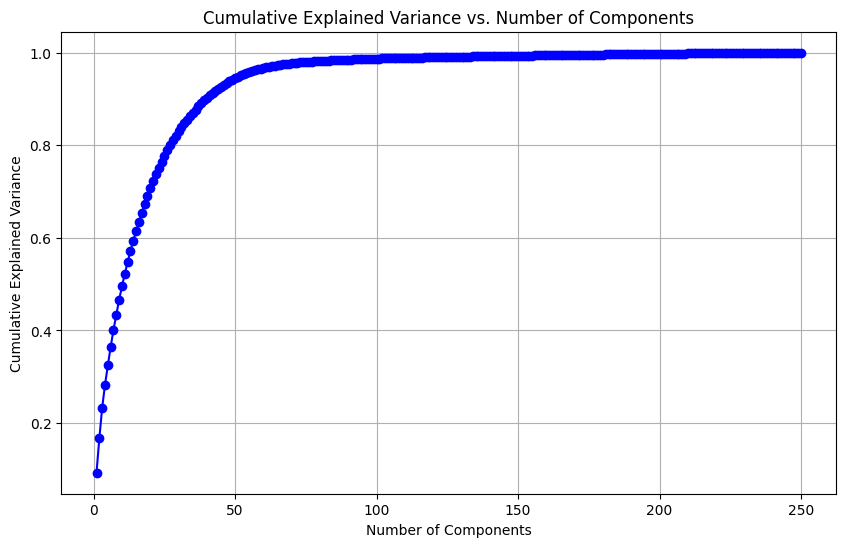

In [7]:
def explain_variance(articles_embedding):
    pca = PCA()
    pca.fit(articles_embedding)
    
    # Plot explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    
    # Plot the explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b')
    plt.title('Cumulative Explained Variance vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

explain_variance(articles_embeddings)

In [15]:
def make_pca(articles_embedding, n_components=100):
    pca = PCA(n_components=n_components)
    articles_embeddings_pca = pca.fit_transform(articles_embedding)
    print(pca.explained_variance_ratio_.sum())
    return articles_embeddings_pca

articles_embeddings_pca = make_pca(articles_embeddings)
with open("articles_embeddings_pca.pkl", "wb") as f:
    pickle.dump(articles_embeddings_pca, f)

0.9871921742615349


###### Comparaison

In [13]:
recommended_articles_scores = getnArticles(16280, 10, articles_embeddings_pca, sorted_articles)
for article_id, score in recommended_articles_scores:
    print(f"Article recommandé : {article_id}, score de similarité : {score} ")

Article recommandé : 104055, score de similarité : 0.807182604755679 
Article recommandé : 167283, score de similarité : 0.7992143144420072 
Article recommandé : 154320, score de similarité : 0.7929122932114215 
Article recommandé : 78631, score de similarité : 0.7907263041562627 
Article recommandé : 105259, score de similarité : 0.7899251043454089 
Article recommandé : 153752, score de similarité : 0.7882547924641521 
Article recommandé : 156100, score de similarité : 0.787737234917686 
Article recommandé : 158005, score de similarité : 0.7866970285843234 
Article recommandé : 157152, score de similarité : 0.7855547206467443 
Article recommandé : 88127, score de similarité : 0.78392994214069 


## Collaborative Filtering Model 

### Approche basée sur un modèle. (SVD++)
SVD++ est une extension de SVD (Décomposition en Valeurs Singulières) qui prend en compte les évaluations implicites des utilisateurs, c'est-à-dire les items que les utilisateurs ont évalués, mais aussi les items avec lesquels les utilisateurs ont interagi d'une manière ou d'une autre (par exemple, cliquer sur un article, ajouter un article à une liste de souhaits, etc.).

In [7]:
sorted_articles[['user_id', 'article_id', 'normalized_popularity']]

,user_id,article_id,normalized_popularity
349865,16280,68851,0.112628
349924,16280,237071,0.112628
349969,16280,363925,0.112628
349859,16280,43032,0.105802
349853,16280,38823,0.102389
...,...,...,...
992352,54285,97590,0.066667
992353,54285,156447,0.066667
992354,54285,156624,0.066667
992355,54285,158646,0.066667


In [8]:
def scale_rating(df, feature_range):
    df = df[['user_id', 'article_id', 'normalized_popularity']]
    X_train, X_test = skl_train_test_split(df, test_size=0.25, random_state=0)
    scaler = MinMaxScaler(feature_range=feature_range)
    X_train['normalized_popularity'] = scaler.fit_transform(X_train[['normalized_popularity']])
    X_test['normalized_popularity'] = scaler.transform(X_test[['normalized_popularity']])
    X = pd.concat([X_test, X_train], axis=0).reset_index(drop=True)
    return X
X = scale_rating(sorted_articles, (0,1))

In [9]:
X.sort_values(by='normalized_popularity', ascending=False)

,user_id,article_id,normalized_popularity
2284344,306741,161580,1.0
2710299,298787,313920,1.0
2710261,236915,42242,1.0
2710266,102634,73500,1.0
1352289,212927,293114,1.0
...,...,...,...
2237489,5890,10344,0.0
2513500,5890,122018,0.0
262195,5890,220854,0.0
714873,5890,207812,0.0


In [13]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(X[['user_id', 'article_id', 'normalized_popularity']], reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=0)

In [14]:
algo = SVDpp()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.3611


0.3611018529028771

- rmse : Compute RMSE (Root Mean Squared Error).

- mse : Compute MSE (Mean Squared Error).

- mae : Compute MAE (Mean Absolute Error).

In [15]:
with open("svd++_algo.pkl", "wb") as f:
    pickle.dump(algo, f)

In [16]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Retourne les N meilleures recommandations pour chaque utilisateur à partir d'un ensemble de prédictions.

    Args:
        predictions(liste d'objets Prediction): La liste des prédictions, telles que
            retournées par la méthode de test d'un algorithme.
        n(int): Le nombre de recommandations à sortir pour chaque utilisateur. Par défaut,
            c'est 10.

    Returns:
    Un dictionnaire où les clés sont les ids des utilisateurs (bruts) et les valeurs sont des listes de tuples :
        [(id de l'article brut, estimation de la note), ...] de taille n.
    """
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_10_svd = get_top_n(predictions, n=10)
top_10_svd

defaultdict(list,
            {140314: [(202398, 0.39094764896934975),
              (71608, 0.35123446294927013),
              (157332, 0.33251627259519895),
              (84942, 0.3083157634627736)],
             5925: [(331116, 0.6964973491287536),
              (234698, 0.6914033152065113),
              (235616, 0.664891123731433),
              (157076, 0.4587622638014697),
              (327984, 0.35917457221709165),
              (283437, 0.30387229909645835),
              (315104, 0.30205005525323336),
              (57475, 0.19606138896179268),
              (304359, 0.04247175088604327)],
             137127: [(70591, 0.7234138434965022)],
             199499: [(331116, 0.7897379444631799)],
             261537: [(234698, 0.9036885567734436)],
             57435: [(272143, 0.6858924391785506),
              (160974, 0.6474193655773904),
              (236951, 0.5350164497720654),
              (161506, 0.5334335034145341),
              (31520, 0.4944559240349152),
      

In [17]:
with open("top_10_svd.txt", "wb") as file:
    pickle.dump(top_10_svd, file)

In [16]:
def svd_function(user_id, all_article_ids, algo, n=10):
    """
    Obtenir les prédictions de score pour un utilisateur et une liste d'articles en utilisant SVD++.
    
    Parameters:
    - user_id (int): L'identifiant de l'utilisateur pour lequel générer des prédictions.
    - all_article_ids (list of int): Une liste d'identifiants d'articles pour lesquels générer des prédictions.
    - algo (object): L'objet SVD++ entraîné.
    
    Returns:
    list of tuples: Liste des tuples (article_id, predicted_score).
    """
    predictions = []
    for article_id in all_article_ids:
        prediction = algo.predict(uid=user_id, iid=article_id)
        predictions.append((article_id, prediction.est))
        
    # Triez les prédictions en ordre décroissant de score
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    return predictions[:n]

# Exemple d'utilisation

all_article_ids = range(article_data.article_id.max())  
user_predictions = svd_function(16280, all_article_ids, algo)
user_predictions

[(96210, 0.5696694440933587),
 (123909, 0.5584085025630903),
 (331116, 0.5582363927143945),
 (162655, 0.5581667328572728),
 (183176, 0.5524988507891433),
 (158536, 0.5496482263579255),
 (234698, 0.5445638441305342),
 (336245, 0.5415038043319519),
 (124749, 0.5401029792176809),
 (233688, 0.5381272673304438)]

### Comparaison Implicit

In [44]:
from tqdm import tqdm
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, ndcg_at_k, AUC_at_k
from time import time

In [37]:
X_train, X_test = skl_train_test_split(X, test_size=0.25, random_state=0)

In [51]:
def train_models(train_df, test_df, models_list, n_recommandations):
    
    '''
    Train recommendation models and provide evaluation metrics.

            Parameters:
                    train_df (Pandas Dataframe): Dataframe containing training interactions datas
                    test_df (Pandas Dataframe): Dataframe containing test interactions datas
                    models_list (List) : Python List containing models to be evaluated
                    n_recommandations (Int) : Integer representing the number of recommandations to provide


            Returns:
                    df_results (Pandas Dataframe): Dataframe containing the results of evaluation performed on the models
    '''
    
    # First, let's initialize a blank results dataframe 
    # Each column correspond to the evaluation metrics to use
    df_results = pd.DataFrame(columns=['model', 'Precision@k','MAP@k','nDCG@k',"train_time"])
    
    # Get dimensions of the sparse matrix    
    dim = (max(train_df.user_id.max(),test_df.user_id.max())+1, max(train_df.article_id.max(),test_df.article_id.max())+1)
    
    # Creating sparse matrix for train and test dataframe
    # Why creating sparse matrix ? : because it is the data format expected by Implicit
    train_csr = csr_matrix((train_df['normalized_popularity'], (train_df['user_id'], train_df['article_id'])), dim)
    test_csr = csr_matrix((test_df['normalized_popularity'], (test_df['user_id'], test_df['article_id'])), dim)
    
    # Iterate over each models to evaluate in the list
    for model in models_list:
        
        print("##"*30)
        print("[INFO] : Start training the model : ", model.__class__.__name__)
        
        # Launch the timer
        train_start_time = time()
        
        # Train the choosen model
        model.fit(train_csr)
        
        # Stop the timer and calculate the training time
        train_time = time() - train_start_time
              
        # Calculate evaluation metrics        
        precision_k = round(precision_at_k(model, train_csr, test_csr), 5)
        map_at_k = round(mean_average_precision_at_k(model, train_csr, test_csr), 5)
        ndcg_k = round(ndcg_at_k(model, train_csr, test_csr), 5)
        print("[INFO] : Precision@k = ", precision_k)
        print("[INFO] : MAP@k = ", map_at_k)
        print("[INFO] : nDCG@k = ", ndcg_k)
        print("##"*30)
        
        # Log results in the results dataframe
        
        new_row = {
        'model': model.__class__.__name__,
        'Precision@k': precision_k,
        'MAP@k': map_at_k,
        'nDCG@k': ndcg_k,
        'train_time': round(train_time,5),
        }

        df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)

    return df_results

In [52]:
models_list = [AlternatingLeastSquares(), BayesianPersonalizedRanking(), LogisticMatrixFactorization()]
train_models(train_df=X_train, test_df=X_test, models_list=models_list, n_recommandations=10)

############################################################
[INFO] : Start training the model :  AlternatingLeastSquares


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/230930 [00:00<?, ?it/s]

  0%|          | 0/230930 [00:00<?, ?it/s]

  0%|          | 0/230930 [00:00<?, ?it/s]

[INFO] : Precision@k =  0.09928
[INFO] : MAP@k =  0.06537
[INFO] : nDCG@k =  0.09529
############################################################
############################################################
[INFO] : Start training the model :  BayesianPersonalizedRanking


C:\Users\aurel\AppData\Local\Temp\ipykernel_8244\47532607.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/230930 [00:00<?, ?it/s]

  0%|          | 0/230930 [00:00<?, ?it/s]

  0%|          | 0/230930 [00:00<?, ?it/s]

[INFO] : Precision@k =  0.12302
[INFO] : MAP@k =  0.08596
[INFO] : nDCG@k =  0.12246
############################################################
############################################################
[INFO] : Start training the model :  LogisticMatrixFactorization


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/230930 [00:00<?, ?it/s]

  0%|          | 0/230930 [00:00<?, ?it/s]

  0%|          | 0/230930 [00:00<?, ?it/s]

[INFO] : Precision@k =  0.02387
[INFO] : MAP@k =  0.00809
[INFO] : nDCG@k =  0.01536
############################################################


,model,Precision@k,MAP@k,nDCG@k,train_time
0,AlternatingLeastSquares,0.09928,0.06537,0.09529,123.36953
1,BayesianPersonalizedRanking,0.12302,0.08596,0.12246,22.05740
2,LogisticMatrixFactorization,0.02387,0.00809,0.01536,14.04720


Bayesian est le meilleur modèle de la librairie Implicit

### Modèle Hybride (SVD++ et CBF)

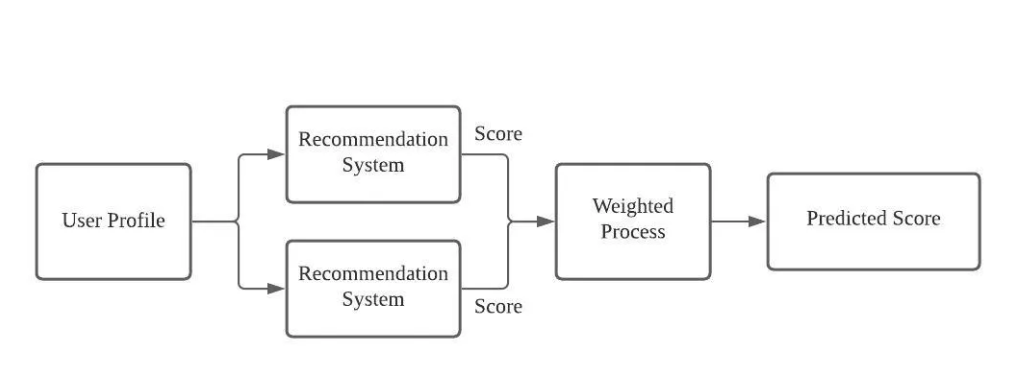

In [13]:
with open("svd++_algo.pkl", "rb") as file:
    algo = pickle.load(file)

In [17]:
def hybrid_recommendation(user_id, w, articles_emb, df_clicks, all_article_ids, algo, n):
    """
    Retourne une liste d'articles recommandés basée sur une combinaison linéaire des scores 
    de similarité de CBF et SVD++.
    """
    
    # Obtenir les recommandations de CBF
    cbf_recommendations = getnArticles(user_id, n, articles_emb, df_clicks)
    print(f"CBF recommandations : \n {cbf_recommendations}")
    
    # Obtenir les recommandations de SVD++
    svd_recommendations = svd_function(user_id, all_article_ids, algo, n)
    print(f"SVD++ recommandations : \n {svd_recommendations}")
    
    # Créer un dictionnaire pour stocker les scores combinés
    combined_scores = {}
    if cbf_recommendations:
        for article_id, score in cbf_recommendations:
            combined_scores[article_id] = w * score
        
    for article_id, score in svd_recommendations:
        if article_id in combined_scores:
            combined_scores[article_id] += (1 - w) * score
        else:
            combined_scores[article_id] = (1 - w) * score
            
    # Trier les articles par score combiné de manière décroissante
    recommended_articles = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    top_recommended = recommended_articles[:n]
    print(f"Hybrid recommandations : \n {top_recommended}")
    
    return top_recommended

# Exemple d'utilisation
all_article_ids = list(range(article_data.article_id.nunique()))  
recommended_articles = hybrid_recommendation(16280, 0.5, articles_embeddings, sorted_articles, all_article_ids, algo, 10)

CBF recommandations : 
 [(152780, 0.771657107166891), (232062, 0.7708506033875672), (235942, 0.7678847021147632), (50079, 0.76736150194865), (36560, 0.7660583146211698), (69378, 0.766043214711556), (102972, 0.7650765849780157), (38526, 0.7649582475032495), (167281, 0.7627212559693993), (156946, 0.7579270459104901)]
SVD++ recommandations : 
 [(96210, 0.5696694440933587), (123909, 0.5584085025630903), (331116, 0.5582363927143945), (162655, 0.5581667328572728), (183176, 0.5524988507891433), (158536, 0.5496482263579255), (234698, 0.5445638441305342), (336245, 0.5415038043319519), (124749, 0.5401029792176809), (233688, 0.5381272673304438)]
Hybrid recommandations : 
 [(152780, 0.3858285535834455), (232062, 0.3854253016937836), (235942, 0.3839423510573816), (50079, 0.383680750974325), (36560, 0.3830291573105849), (69378, 0.383021607355778), (102972, 0.38253829248900784), (38526, 0.38247912375162474), (167281, 0.38136062798469966), (156946, 0.37896352295524505)]


In [23]:
recommended_articles = hybrid_recommendation(138807, 0.5, articles_embeddings, sorted_articles, all_article_ids, algo, 10)

CBF recommandations : 
 [(298790, 0.8116308819672742), (284163, 0.8062879923337105), (304492, 0.8006815883874397), (323451, 0.7977896955189318), (285888, 0.792913046735506), (345958, 0.7828862509643916), (281525, 0.7789422939731339), (285606, 0.7789326398598154), (14365, 0.7785205866212287), (345750, 0.777903459314596)]
SVD++ recommandations : 
 [(96210, 0.8883622332047799), (162655, 0.8787569798784074), (123909, 0.8776916043196508), (183176, 0.8775048622136119), (158536, 0.8755651946836103), (331116, 0.8739142087200367), (234698, 0.8704397108569806), (168623, 0.8684221214950317), (161178, 0.8602111377453838), (272143, 0.8576406128363474)]
Hybrid recommandations : 
 [(96210, 0.44418111660238996), (162655, 0.4393784899392037), (123909, 0.4388458021598254), (183176, 0.43875243110680595), (158536, 0.43778259734180514), (331116, 0.43695710436001833), (234698, 0.4352198554284903), (168623, 0.43421106074751586), (161178, 0.4301055688726919), (272143, 0.4288203064181737)]


In [26]:
clicks_data.user_id.max()

322896

In [22]:
recommended_articles = hybrid_recommendation(323000, 0.5, articles_embeddings, sorted_articles, all_article_ids, algo, 10)

User 323000 has not read any articles yet!
CBF recommandations : 
 None
SVD++ recommandations : 
 [(96210, 0.8385981390277528), (234698, 0.8231448175872558), (331116, 0.8202382505150136), (336223, 0.8169608227833491), (272143, 0.8159203929068926), (183176, 0.8131328131490847), (123909, 0.8130282314273252), (158536, 0.8087904327944409), (162655, 0.8049006330387456), (64329, 0.8038951362265079)]
Hybrid recommandations : 
 [(96210, 0.4192990695138764), (234698, 0.4115724087936279), (331116, 0.4101191252575068), (336223, 0.40848041139167457), (272143, 0.4079601964534463), (183176, 0.40656640657454235), (123909, 0.4065141157136626), (158536, 0.4043952163972204), (162655, 0.4024503165193728), (64329, 0.40194756811325394)]


Pour certains utilisateurs, les recommandations de CBF auront un score plus élevé que les recommandations de SVD++, le poids W peut être ajusté pour donner plus d'importance à SVD++.  
Si W > 0.5, on donne plus d'importance à CBF  
Si W < 0.5, on donne plus d'importance à SVD++

--------------------------------